In [197]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats

data.csv includes lastest edition FIFA 2019 players attributes like Age, Nationality, Overall, Club,              
Wage, Preferred_Foot, Position, Height, Weight, ShortPassing, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Positioning, Penalties.  

Возраст, Национальность, Общий, Клуб, Заработная плата, Предпочтительная нога,
        Положение, рост, вес, шортпассинг, точность FK,
        Long Passing, контроль мяча, ускорение, скорость спринта, ловкость,
        Реакции, баланс, сила удара, прыжки, выносливость, сила,
        Длинные выстрелы, Позиционирование, Пенальти

In [22]:
master_data=pd.read_csv('data.csv')
master_data.head()
master_data.drop(columns = ['Unnamed: 0','Name','ID','WorkRate','BodyType','RealFace','LoanedFrom','Value','InternationalReputation','Joined','WeakFoot','GKDiving', 'GKHandling','GKKicking', 'GKPositioning','Aggression','Vision','Vision','Special', 'SkillMoves','Volleys', 'Dribbling', 'Curve','Interceptions', 'HeadingAccuracy','Crossing', 'Potential','Finishing', 'GKReflexes', 'ReleaseClause','ContractValidUntil','JerseyNumber','Flag','ClubLogo','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Photo','Composure', 'Marking', 'StandingTackle', 'SlidingTackle'], inplace=True)
master_data.columns.str.strip()
master_data.rename(columns = {'PreferredFoot':'Preferred_Foot'                              
                             }, inplace = True)
master_data.fillna(0, inplace=True)
# 

Подготовка данных, убираем NaN значения и обрабатываем категориальные признаки

In [23]:
master_data['Wage'] = master_data.Wage.str.replace('€','')
master_data['Wage'] = master_data.Wage.str.replace('K','000')
master_data['Wage'] = master_data.Wage.astype('int64')
master_data['Weight'] = master_data.Weight.str.replace('lbs','').astype('float64')
master_data['Height'] = master_data.Height.str.replace('\'','.').astype('float64')
master_data.fillna(0, inplace=True)

In [24]:
master_data['Preferred_Foot'] = master_data.Preferred_Foot.astype('category')
master_data['Nationality'] = master_data.Nationality.astype('category')
master_data['Club'] = master_data.Club.astype('category')
master_data['Position'] = master_data.Position.astype('category')
master_data['Weight'] = master_data.Weight*0.454
master_data['Height'] = master_data.Height*30

In [25]:
master_data.head()

,Age,Nationality,Overall,Club,Wage,Preferred_Foot,Position,Height,Weight,ShortPassing,...,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Positioning,Penalties
0,31,Argentina,94,FCBarcelona,565000,Left,RF,171.0,72.186,90.0,...,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,94.0,75.0
1,33,Portugal,94,Juventus,405000,Right,ST,186.0,83.082,81.0,...,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,95.0,85.0
2,26,Brazil,92,ParisSaint-Germain,290000,Right,LW,177.0,68.100,84.0,...,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,89.0,81.0
3,27,Spain,91,ManchesterUnited,260000,Right,GK,192.0,76.272,50.0,...,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,12.0,40.0
4,27,Belgium,91,ManchesterCity,355000,Right,RCM,153.3,69.916,92.0,...,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,87.0,79.0


In [195]:
master_data.columns
# master_data.dtypes


Index(['Age', 'Nationality', 'Overall', 'Club', 'Wage', 'Preferred_Foot',
       'Position', 'Height', 'Weight', 'ShortPassing', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Positioning', 'Penalties'],
      dtype='object')

point 2

In [194]:
cols = ['Mean', 'Mode', 'Median', 'Variance', 'Skew', 'Kurtosis', 'Range', 'Std', 'k variation']
temp= []
dt_stat = pd.DataFrame(columns=cols)
pre_dt = 0
for name, values in master_data.iteritems():
    if (master_data[name].dtype.name != 'category'):
#         temp.append(name)
        temp.append(statistics.mean(master_data[name]))
        temp.append(statistics.mode(master_data[name]))
        temp.append(statistics.median(master_data[name]))
        temp.append(statistics.variance(master_data[name]))
        temp.append(stats.skew(master_data[name]))
        temp.append(stats.kurtosis(master_data[name]))
        temp.append(np.max(master_data[name])-np.min(master_data[name]))
        temp.append(np.std(master_data[name]))
        temp.append(np.std(master_data[name])/statistics.mean(master_data[name])*100)  
        dt_stat.loc[name] = temp
        temp=[]
        pre_dt = pre_dt+1
print(dt_stat)
# plt.figure(figsize=(8, 12))
# sn.heatmap(dt_stat['Mean'].values, annot=True)
# master_data.columns
        

                     Mean     Mode   Median      Variance      Skew  \
Age             25.122206    21.00    25.00  2.180836e+01  0.391732   
Overall         66.238699    66.00    66.00  4.773331e+01  0.067179   
Wage          9731.312133  1000.00  3000.00  4.839688e+08  7.905368   
Height         173.462498   180.00   177.00  2.598840e+02 -3.541539   
Weight          75.155864    74.91    74.91  6.491681e+01 -1.936397   
ShortPassing    58.531993    64.00    62.00  2.245620e+02 -1.163097   
FKAccuracy      42.750151    42.00    41.00  3.095328e+02  0.081002   
LongPassing     52.572966    62.00    56.00  2.416305e+02 -0.645523   
BallControl     58.215576    65.00    63.00  2.866672e+02 -1.291151   
Acceleration    64.443730    69.00    67.00  2.332294e+02 -0.925578   
SprintSpeed     64.556324    68.00    67.00  2.250720e+02 -0.947072   
Agility         63.336189    68.00    66.00  2.280655e+02 -0.721570   
Reactions       61.673587    65.00    62.00  9.102917e+01 -0.762404   
Balanc

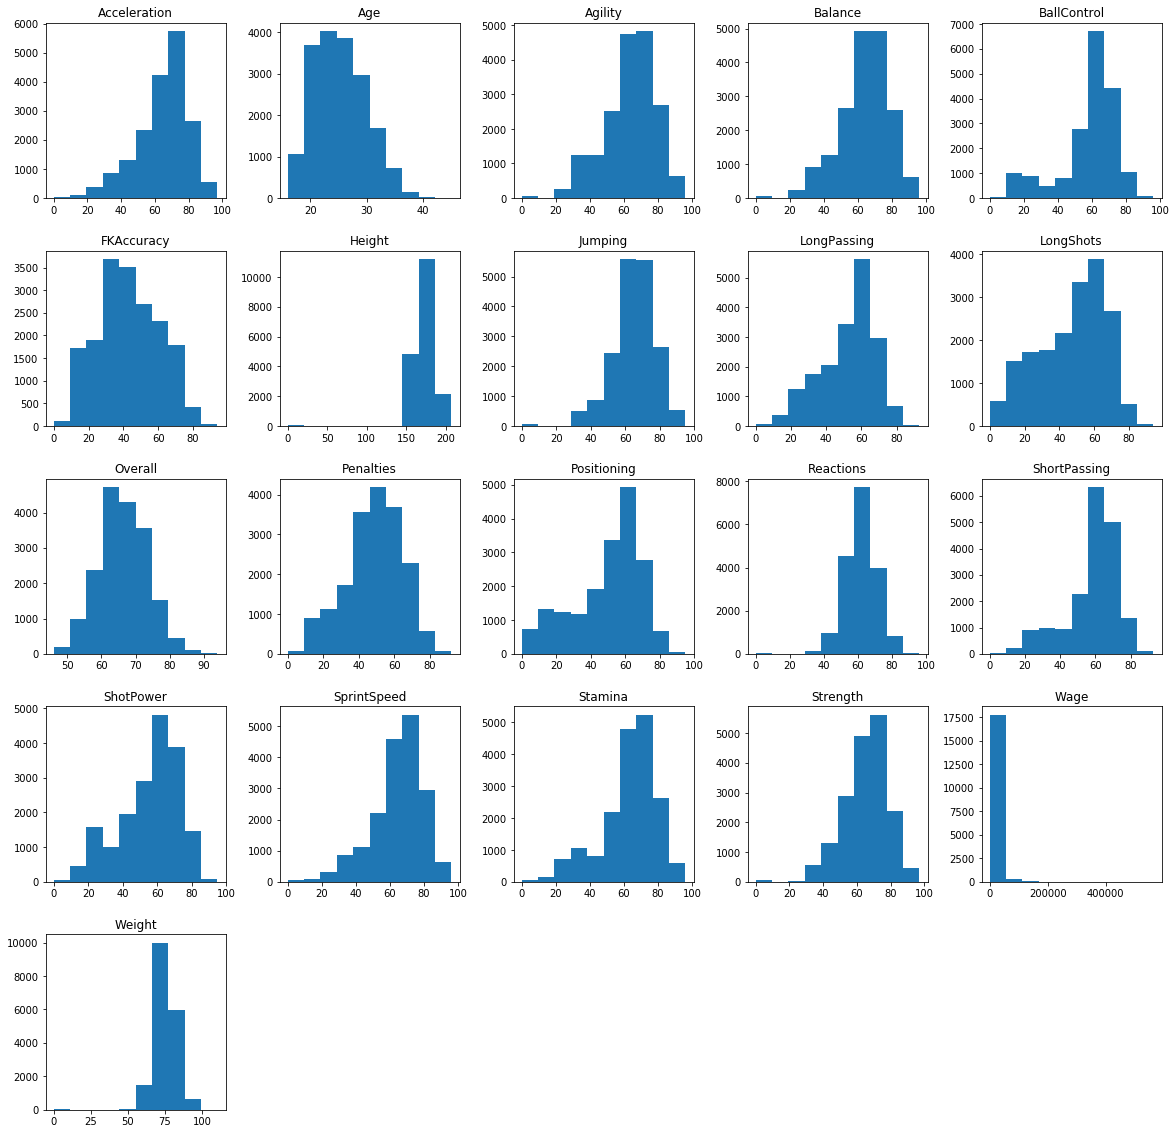

In [30]:
# Print histograms for each feature to see how they vary
histohrams = master_data.hist(grid=False, figsize=(20, 20))

point 3

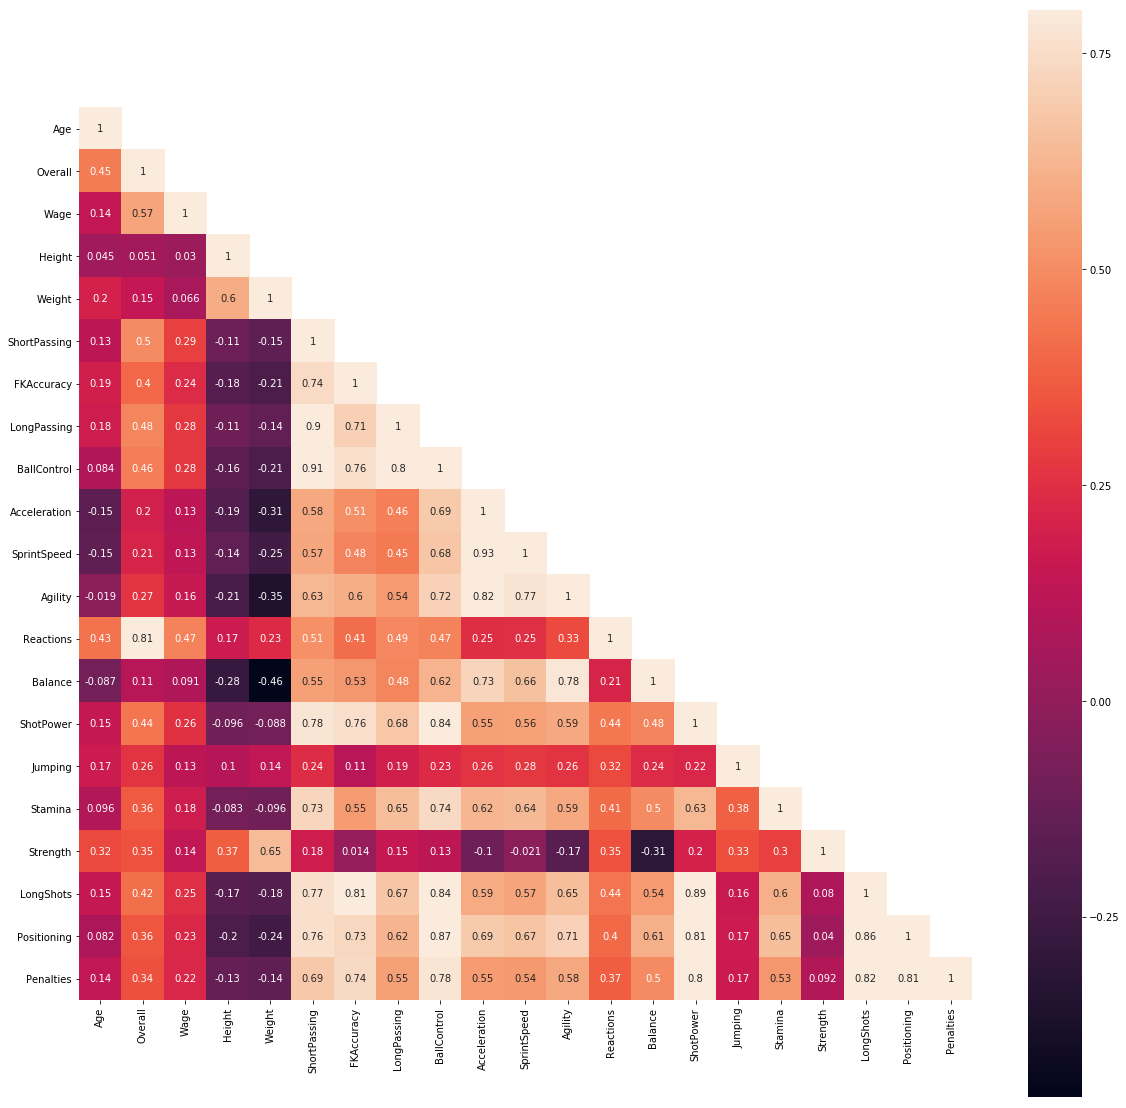

In [27]:
corr = master_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corr, mask=mask, vmax=.8, square=True, annot = True)

point 4

Training data set will be used for training of our linear model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

In [28]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position'], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

Коэффициенты регрессии

In [92]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, Y_train)
cdf = pd.DataFrame(lin_reg.coef_,X.columns, columns=['Coefficients'])
print(cdf)
print("Independent term in the model "+ str(lin_reg.intercept_))

              Coefficients
Age               0.210619
Wage              0.000077
Height           -0.029675
Weight           -0.069606
ShortPassing      0.018997
FKAccuracy        0.002363
LongPassing       0.011085
BallControl       0.062237
Acceleration      0.021698
SprintSpeed       0.024211
Agility           0.013751
Reactions         0.434753
Balance          -0.099007
ShotPower         0.023230
Jumping           0.005292
Stamina          -0.022979
Strength          0.033413
LongShots         0.021284
Positioning      -0.053960
Penalties        -0.027946
Independent term in the model 41.53265390043971


In [62]:
Y_pred = lin_reg.predict(X_test)
print('Prediction:', Y_pred)
# средне квадратическая ошибка
mse = mean_squared_error(Y_test, Y_pred)
print('mean_squared_error : ',mse)

Prediction: [59.76446946 67.70894355 76.71052127 ... 63.73108116 70.20700856
 62.82540958]
mean_squared_error :  11.509057274074737


In [74]:
alfa = 0.05
n = Y_pred.size-1
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
print ("среднее: ", Y_pred)
print ("<queue_mean>", np.mean(Y_pred), "</queue_mean>")
print ("<queue_di>", tcr*np.std(Y_pred)/np.sqrt(Y_pred.size), "</queue_di>")

среднее:  [59.76446946 67.70894355 76.71052127 ... 63.73108116 70.20700856
 62.82540958]
<queue_mean> 66.21824722437266 </queue_mean>
<queue_di> 0.14097016258113518 </queue_di>


In [86]:
#R^2 (coefficient of determination) regression score function.
r2 = r2_score(Y_test, Y_pred)
print('r2 score from scipy: ',r2)
r2_adj = 1-((1-r2*r2)*(Y_pred.size-1)/(Y_pred.size-1-len(X_test.columns)))
print('r2_adj', r2_adj)

r2 score from scipy:  0.7601435525730329
r2_adj 0.576655505620302


In [199]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1753.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:08:36   Log-Likelihood:                -28736.
No. Observations:               10924   AIC:                         5.751e+04
Df Residuals:                   10903   BIC:                         5.767e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.5327      0.515     80.676   

In [200]:
abs(est2.tvalues) > tcr

const            True
Age              True
Wage             True
Height           True
Weight           True
ShortPassing     True
FKAccuracy      False
LongPassing      True
BallControl      True
Acceleration     True
SprintSpeed      True
Agility          True
Reactions        True
Balance          True
ShotPower        True
Jumping         False
Stamina          True
Strength         True
LongShots        True
Positioning      True
Penalties        True
dtype: bool

Незначимы: FKAccuracy, LongPassing, Jumping

In [201]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           256.132394
Age               1.528405
Wage              1.345426
Height            1.635938
Weight            2.791895
ShortPassing     12.542286
FKAccuracy        3.799623
LongPassing       6.322731
BallControl      12.571043
Acceleration      9.165580
SprintSpeed       7.623981
Agility           4.663549
Reactions         2.287269
Balance           3.488315
ShotPower         6.476000
Jumping           1.485703
Stamina           3.239853
Strength          3.099019
LongShots         7.829533
Positioning       6.707692
Penalties         4.029803
dtype: float64

Получается так. Часто используют границу 5 или 10, если показатель VIF больше данного значения - есть линейная зависимость от остальных переменных

In [203]:
col = ['Wage']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.34029483090995283


In [204]:
col.append('Age')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.477347507064966


In [206]:
col.append('Reactions')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7238699208263


In [207]:
col.append('Balance')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7255517352755303


In [208]:
col.append('Height')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7334620150386602


In [209]:
col.append('Weight')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7344949315099482


In [210]:
col.append('BallControl')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.7505457918756179


In [212]:
col.append('Positioning')
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.rsquared_adj)

0.753753204808122


In [213]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     4180.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:13:10   Log-Likelihood:                -28936.
No. Observations:               10924   AIC:                         5.789e+04
Df Residuals:                   10915   BIC:                         5.796e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          41.6029      0.510     81.510      

In [214]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

C:\Users\Daria_Riazanova\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning:

divide by zero encountered in double_scalars



const          242.990226
Wage             1.333235
Age              1.294017
Reactions             inf
Reactions             inf
Balance          2.075113
Height           1.624742
Weight           2.022282
BallControl      4.650086
Positioning           inf
Positioning           inf
dtype: float64

In [215]:
np.linalg.cond(est2.model.exog)

1.422205107617913e+19

In [217]:
np.abs(est2.params/np.std(Y_train)*np.std(X_train[col])).sort_values(ascending = False)

Reactions      0.308085
Reactions      0.308085
Reactions      0.308085
Reactions      0.308085
BallControl    0.272646
Wage           0.238674
Balance        0.174324
Age            0.140098
Height         0.068086
Positioning    0.058237
Positioning    0.058237
Positioning    0.058237
Positioning    0.058237
Weight         0.045022
const               NaN
dtype: float64

In [219]:
np.abs(est2.params/np.mean(Y_train)*np.mean(X_train[col])).sort_values(ascending = False)

Reactions      0.207373
Reactions      0.207373
Reactions      0.207373
Reactions      0.207373
BallControl    0.097551
Balance        0.079984
Age            0.078713
Height         0.075846
Weight         0.043430
Positioning    0.015369
Positioning    0.015369
Positioning    0.015369
Positioning    0.015369
Wage           0.011374
const               NaN
dtype: float64

In [220]:
np.mean(lin_reg.predict(X_train) - Y_train)

-4.020381407664939e-15

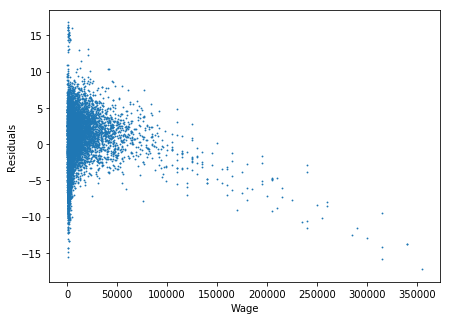

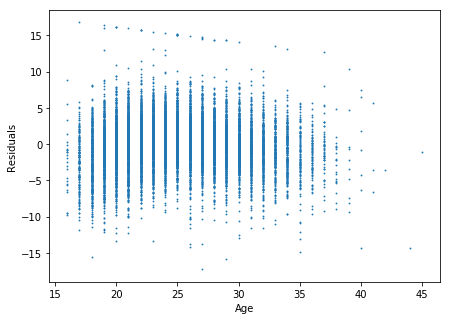

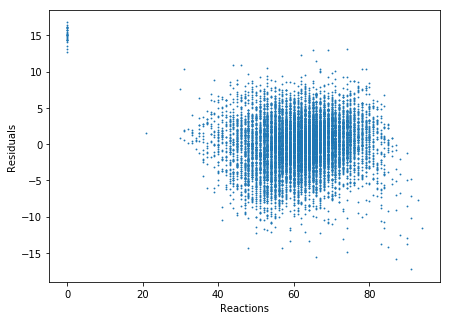

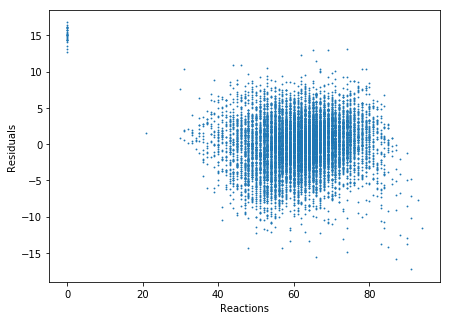

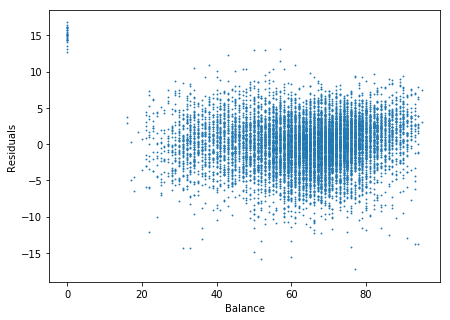

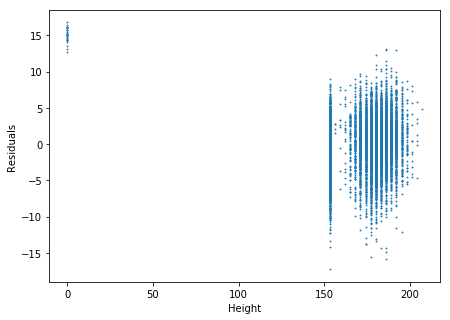

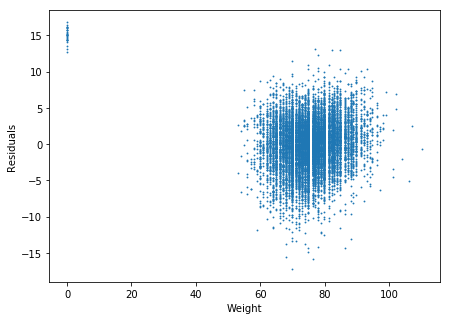

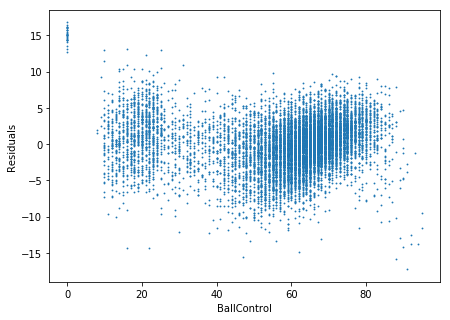

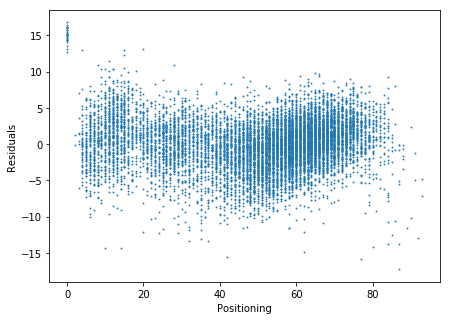

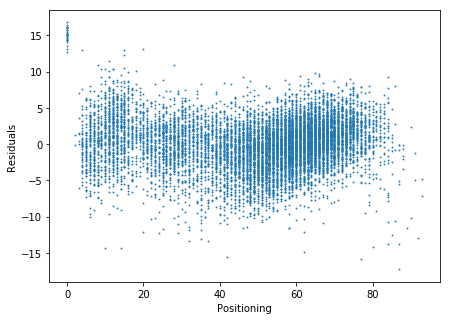

In [221]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [222]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(est2.resid, est2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 2843.3751194337865),
 ('p-value', 0.0),
 ('f-value', 480.09033780388023),
 ('f p-value', 0.0)]

In [223]:
durbin_watson(est2.resid)

1.9785937718525815

~2, следовательно, нет автокорреляциии